In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import rasterio
from torch.utils.data import Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 41.1 MB/s eta 0:00:00


In [ ]:
class SARFloodDataset(Dataset):
    def __init__(self, sar_dir, gt_dir, transform=None):
        self.sar_dir = sar_dir
        self.gt_dir = gt_dir
        self.sar_images = sorted(os.listdir(sar_dir))
        self.gt_masks = sorted(os.listdir(gt_dir))
        self.transform = transform

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar_path = os.path.join(self.sar_dir, self.sar_images[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_masks[idx])

        sar_image = self.load_sar_image(sar_path)
        gt_mask = self.load_mask(gt_path)

        # Apply transformations (if any)
        if self.transform:
            sar_image = self.transform(sar_image)

        return sar_image, gt_mask

    def load_sar_image(self, file_path):
        with rasterio.open(file_path) as src:
            sar_data = src.read()  # Read all bands
        return sar_data.astype(np.float32)

    def load_mask(self, file_path):
        with rasterio.open(file_path) as src:
            mask_data = src.read(1)  # Read the first channel (mask) with class values
        return mask_data.astype(np.int64)


In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import rasterio
import segmentation_models_pytorch as smp


In [ ]:
# Define paths to the directories containing SAR images and GT masks
sar_dir = "/content/drive/MyDrive/FU/SAR"  # Path to SAR images
gt_dir = "/content/drive/MyDrive/FU/GT"    # Path to GT masks

# Create dataset and DataLoader
dataset = SARFloodDataset(sar_dir=sar_dir, gt_dir=gt_dir)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Adjust batch_size as needed


In [ ]:
import segmentation_models_pytorch as smp

# Define the U-Net model
model = smp.Unet(
    encoder_name="resnet34",        # Use ResNet34 as encoder
    encoder_weights=None,           # No pre-trained weights
    in_channels=8,                  # 8 input channels (SAR data with 8 bands)
    classes=3                       # 3 output classes (non-flooded, open flooded, urban flooded)
)

# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
# Loss function
criterion = torch.nn.CrossEntropyLoss()  # No one-hot encoding, use CrossEntropyLoss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def compute_confusion_metrics(predictions, ground_truth, num_classes=3):
    """
    Compute confusion matrix, precision, recall, f1-score, accuracy, and MCC based on
    true positive, true negative, false positive, and false negative for each class.
    """

    # Flatten the predictions and ground truth for pixel-wise comparison
    predictions = predictions.flatten()
    ground_truth = ground_truth.flatten()

    # Initialize containers for confusion metrics
    TP, TN, FP, FN = np.zeros(num_classes), np.zeros(num_classes), np.zeros(num_classes), np.zeros(num_classes)

    for class_id in range(num_classes):
        TP[class_id] = ((predictions == class_id) & (ground_truth == class_id)).sum()  # True Positive
        TN[class_id] = ((predictions != class_id) & (ground_truth != class_id)).sum()  # True Negative
        FP[class_id] = ((predictions == class_id) & (ground_truth != class_id)).sum()  # False Positive
        FN[class_id] = ((predictions != class_id) & (ground_truth == class_id)).sum()  # False Negative

    # Compute precision, recall, F1-score per class
    precision_per_class = TP / (TP + FP + 1e-8)  # Avoid division by zero
    recall_per_class = TP / (TP + FN + 1e-8)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8)

    # Overall accuracy: total correct pixels divided by total pixels
    accuracy = (TP.sum() + TN.sum()) / (TP.sum() + TN.sum() + FP.sum() + FN.sum())

    # Compute Matthews Correlation Coefficient (MCC)
    mcc_per_class = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) + 1e-8)

    return precision_per_class, recall_per_class, f1_per_class, accuracy, mcc_per_class


In [ ]:
# Training loop for 100 epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for sar_image, gt_mask in data_loader:
        sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

        optimizer.zero_grad()
        outputs = model(sar_image)

        # Compute loss
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0

    total_TP, total_TN, total_FP, total_FN = np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3)

    with torch.no_grad():
        for sar_image, gt_mask in data_loader:  # Use the same data_loader for evaluation
            sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

            outputs = model(sar_image)
            loss = criterion(outputs, gt_mask)
            test_loss += loss.item()

            # Get predicted masks (argmax to get predicted class per pixel)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            ground_truth = gt_mask.cpu().numpy()

            # Calculate TP, TN, FP, FN, etc.
            precision_per_class, recall_per_class, f1_per_class, accuracy, mcc_per_class = compute_confusion_metrics(predictions, ground_truth)

    # Print results for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(data_loader):.4f}")
    print(f"Test Loss: {test_loss / len(data_loader):.4f}")
    print(f"Precision (per class): {precision_per_class}")
    print(f"Recall (per class): {recall_per_class}")
    print(f"F1 Score (per class): {f1_per_class}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"MCC (per class): {mcc_per_class}")

    # Save model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/unet_model_epoch_{epoch+1}.pth")


Epoch 1/100
Train Loss: 0.7751
Test Loss: 0.5124
Precision (per class): [0.99782331 0.34856741 0.00254415]
Recall (per class): [0.96756949 0.80531189 0.03700479]
F1 Score (per class): [0.98246354 0.48654218 0.00476097]
Overall Accuracy: 0.9766
MCC (per class): [0.3664094  0.52472387 0.00418089]
Epoch 2/100
Train Loss: 0.4133
Test Loss: 0.2944
Precision (per class): [9.90337278e-01 8.55654891e-01 6.81663258e-04]
Recall (per class): [9.95852317e-01 6.88311688e-01 6.34920635e-04]
F1 Score (per class): [9.93087135e-01 7.62914517e-01 6.57457202e-04]
Overall Accuracy: 0.9910
MCC (per class): [ 7.34507302e-01  7.61710653e-01 -3.08837830e-04]
Epoch 3/100
Train Loss: 0.2619
Test Loss: 0.2054
Precision (per class): [0.99329563 0.75034316 0.        ]
Recall (per class): [0.99791386 0.49541529 0.        ]
F1 Score (per class): [0.99559938 0.59679542 0.        ]
Overall Accuracy: 0.9942
MCC (per class): [ 5.86779005e-01  6.06008058e-01 -2.49840413e-04]
Epoch 4/100
Train Loss: 0.1905
Test Loss: 0.15

KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import rasterio
import segmentation_models_pytorch as smp


In [ ]:
class SARFloodDataset(Dataset):
    def __init__(self, sar_dir, gt_dir, transform=None):
        self.sar_dir = sar_dir
        self.gt_dir = gt_dir
        self.sar_images = sorted(os.listdir(sar_dir))  # Assuming all images have .tif extension
        self.gt_masks = sorted(os.listdir(gt_dir))  # Assuming GT images are in the corresponding folder
        self.transform = transform

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar_path = os.path.join(self.sar_dir, self.sar_images[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_masks[idx])

        sar_image = self.load_sar_image(sar_path)
        gt_mask = self.load_mask(gt_path)

        # Apply transformations (if any)
        if self.transform:
            sar_image = self.transform(sar_image)

        return sar_image, gt_mask

    def load_sar_image(self, file_path):
        with rasterio.open(file_path) as src:
            sar_data = src.read()  # Read all bands
        return sar_data.astype(np.float32)

    def load_mask(self, file_path):
        with rasterio.open(file_path) as src:
            mask_data = src.read(1)  # Read the first channel (mask)
        return mask_data.astype(np.int64)  # Assuming class values are integers (0, 1, 2)


In [ ]:
# Define paths to the directories containing SAR images and GT masks
sar_dir = "/content/drive/MyDrive/FU/SAR"  # Path to SAR images
gt_dir = "/content/drive/MyDrive/FU/GT"    # Path to GT masks

# Create dataset and DataLoader
dataset = SARFloodDataset(sar_dir=sar_dir, gt_dir=gt_dir)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Adjust batch_size as needed


In [ ]:
# Define the U-Net model
model = smp.Unet(
    encoder_name="resnet34",        # Use ResNet34 as encoder
    encoder_weights=None,           # No pre-trained weights
    in_channels=8,                  # 8 input channels (SAR data with 8 bands)
    classes=3                       # 3 output classes (non-flooded, open flooded, urban flooded)
)

# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
# Loss function
criterion = torch.nn.CrossEntropyLoss()  # No class weights

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def compute_metrics(predictions, ground_truth, num_classes=3):
    """
    Compute confusion matrix, precision, recall, f1-score, accuracy, and MCC.
    """

    # Flatten the predictions and ground truth for pixel-wise comparison
    predictions = predictions.flatten()
    ground_truth = ground_truth.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(ground_truth, predictions, labels=range(num_classes))
    TP = cm.diagonal()  # True Positives
    FP = cm.sum(axis=0) - TP  # False Positives
    FN = cm.sum(axis=1) - TP  # False Negatives
    TN = cm.sum() - (FP + FN + TP)  # True Negatives

    # Class-wise metrics
    precision_per_class = TP / (TP + FP + 1e-8)
    recall_per_class = TP / (TP + FN + 1e-8)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8)

    # Overall metrics
    total_TP = TP.sum()  # Total True Positives
    total_TN = TN.sum()  # Total True Negatives
    total_FP = FP.sum()  # Total False Positives
    total_FN = FN.sum()  # Total False Negatives

    # Overall precision, recall, F1 score, and accuracy
    overall_precision = total_TP / (total_TP + total_FP + 1e-8)
    overall_recall = total_TP / (total_TP + total_FN + 1e-8)
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall + 1e-8)
    overall_accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN)

    # Compute Matthews Correlation Coefficient (MCC)
    overall_mcc = (total_TP * total_TN - total_FP * total_FN) / np.sqrt((total_TP + total_FP) * (total_TP + total_FN) * (total_TN + total_FP) * (total_TN + total_FN) + 1e-8)

    return precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy, overall_mcc


In [ ]:
# Training loop for 100 epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for sar_image, gt_mask in data_loader:
        sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

        optimizer.zero_grad()
        outputs = model(sar_image)

        # Compute loss
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0

    with torch.no_grad():
        for sar_image, gt_mask in data_loader:  # Use the same data_loader for evaluation
            sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

            outputs = model(sar_image)
            loss = criterion(outputs, gt_mask)  # Use argmax for loss calculation
            test_loss += loss.item()

            # Get predicted masks (argmax to get predicted class per pixel)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            ground_truth = gt_mask.cpu().numpy()

            # Calculate metrics
            precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy, overall_mcc = compute_metrics(predictions, ground_truth)

    # Print results for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(data_loader):.4f}")
    print(f"Test Loss: {test_loss / len(data_loader):.4f}")
    print(f"Precision (per class): {precision_per_class}")
    print(f"Recall (per class): {recall_per_class}")
    print(f"F1 Score (per class): {f1_per_class}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Overall MCC: {overall_mcc:.4f}")

    # Save model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/unet_model_epoch_{epoch + 1}.pth")


KeyboardInterrupt: 

In [ ]:
# Training loop for 100 epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for sar_image, gt_mask in data_loader:
        sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

        optimizer.zero_grad()
        outputs = model(sar_image)

        # Compute loss
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0

    total_TP, total_TN, total_FP, total_FN = np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3)

    with torch.no_grad():
        for sar_image, gt_mask in data_loader:  # Use the same data_loader for evaluation
            sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

            outputs = model(sar_image)
            loss = criterion(outputs, gt_mask)
            test_loss += loss.item()

            # Get predicted masks (argmax to get predicted class per pixel)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            ground_truth = gt_mask.cpu().numpy()

            # Calculate TP, TN, FP, FN, etc.
            precision_per_class, recall_per_class, f1_per_class, accuracy, mcc_per_class = compute_confusion_metrics(predictions, ground_truth)

    # Print results for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(data_loader):.4f}")
    print(f"Test Loss: {test_loss / len(data_loader):.4f}")
    print(f"Precision (per class): {precision_per_class}")
    print(f"Recall (per class): {recall_per_class}")
    print(f"F1 Score (per class): {f1_per_class}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"MCC (per class): {mcc_per_class}")

    # Save model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/unet_model_epoch_{epoch+1}.pth")


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import rasterio
import segmentation_models_pytorch as smp


In [ ]:
class SARFloodDataset(Dataset):
    def __init__(self, sar_dir, gt_dir, transform=None):
        self.sar_dir = sar_dir
        self.gt_dir = gt_dir
        self.sar_images = sorted(os.listdir(sar_dir))  # Assuming all images have .tif extension
        self.gt_masks = sorted(os.listdir(gt_dir))  # Assuming GT images are in the corresponding folder
        self.transform = transform

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar_path = os.path.join(self.sar_dir, self.sar_images[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_masks[idx])

        sar_image = self.load_sar_image(sar_path)
        gt_mask = self.load_mask(gt_path)

        # Apply transformations (if any)
        if self.transform:
            sar_image = self.transform(sar_image)

        return sar_image, gt_mask

    def load_sar_image(self, file_path):
        with rasterio.open(file_path) as src:
            sar_data = src.read()  # Read all bands
        return sar_data.astype(np.float32)

    def load_mask(self, file_path):
        with rasterio.open(file_path) as src:
            mask_data = src.read(1)  # Read the first channel (mask)
        return mask_data.astype(np.int64)  # Assuming class values are integers (0, 1, 2)


In [ ]:
# Define paths to the directories containing SAR images and GT masks
sar_dir = "/content/drive/MyDrive/FU/SAR"  # Path to SAR images
gt_dir = "/content/drive/MyDrive/FU/GT"    # Path to GT masks

# Create dataset and DataLoader
dataset = SARFloodDataset(sar_dir=sar_dir, gt_dir=gt_dir)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Adjust batch_size as needed


In [ ]:
# Define the U-Net model
model = smp.Unet(
    encoder_name="resnet34",        # Use ResNet34 as encoder
    encoder_weights=None,           # No pre-trained weights
    in_channels=8,                  # 8 input channels (SAR data with 8 bands)
    classes=3                       # 3 output classes (non-flooded, open flooded, urban flooded)
)

# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
# Loss function
criterion = torch.nn.CrossEntropyLoss()  # No class weights

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def compute_confusion_metrics(predictions, ground_truth, num_classes=3):
    """
    Compute confusion matrix, precision, recall, f1-score, accuracy, and MCC based on
    true positive, true negative, false positive, and false negative for each class.
    """

    # Flatten the predictions and ground truth for pixel-wise comparison
    predictions = predictions.flatten()
    ground_truth = ground_truth.flatten()

    # Initialize containers for confusion metrics
    TP = np.zeros(num_classes)  # True Positives
    TN = np.zeros(num_classes)  # True Negatives
    FP = np.zeros(num_classes)  # False Positives
    FN = np.zeros(num_classes)  # False Negatives

    for class_id in range(num_classes):
        TP[class_id] = ((predictions == class_id) & (ground_truth == class_id)).sum()  # True Positive
        TN[class_id] = ((predictions != class_id) & (ground_truth != class_id)).sum()  # True Negative
        FP[class_id] = ((predictions == class_id) & (ground_truth != class_id)).sum()  # False Positive
        FN[class_id] = ((predictions != class_id) & (ground_truth == class_id)).sum()  # False Negative

    # Compute precision, recall, F1-score per class
    precision_per_class = TP / (TP + FP + 1e-8)  # Avoid division by zero
    recall_per_class = TP / (TP + FN + 1e-8)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8)

    # Overall metrics
    total_TP = TP.sum()  # Total True Positives
    total_TN = TN.sum()  # Total True Negatives
    total_FP = FP.sum()  # Total False Positives
    total_FN = FN.sum()  # Total False Negatives

    # Overall precision, recall, F1 score, and accuracy
    overall_precision = total_TP / (total_TP + total_FP + 1e-8)
    overall_recall = total_TP / (total_TP + total_FN + 1e-8)
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall + 1e-8)
    overall_accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN)

    # Compute Matthews Correlation Coefficient (MCC)
    overall_mcc = (total_TP * total_TN - total_FP * total_FN) / np.sqrt(
        (total_TP + total_FP) * (total_TP + total_FN) * (total_TN + total_FP) * (total_TN + total_FN) + 1e-8)

    return (precision_per_class, recall_per_class, f1_per_class,
            overall_precision, overall_recall, overall_f1,
            overall_accuracy, overall_mcc)


In [ ]:
# Training loop for 100 epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for sar_image, gt_mask in data_loader:
        sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

        optimizer.zero_grad()
        outputs = model(sar_image)

        # Compute loss
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0

    with torch.no_grad():
        for sar_image, gt_mask in data_loader:  # Use the same data_loader for evaluation
            sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

            outputs = model(sar_image)
            loss = criterion(outputs, gt_mask)  # Use argmax for loss calculation
            test_loss += loss.item()

            # Get predicted masks (argmax to get predicted class per pixel)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            ground_truth = gt_mask.cpu().numpy()

            # Calculate metrics
            precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy, overall_mcc = compute_confusion_metrics(predictions, ground_truth)

    # Print results for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(data_loader):.4f}")
    print(f"Test Loss: {test_loss / len(data_loader):.4f}")
    print(f"Precision (per class): {precision_per_class}")
    print(f"Recall (per class): {recall_per_class}")
    print(f"F1 Score (per class): {f1_per_class}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Overall MCC: {overall_mcc:.4f}")

    # Save model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/unet_model_epoch_{epoch + 1}.pth")


Epoch 1/100
Train Loss: 0.8190
Test Loss: 0.6157
Precision (per class): [9.96614596e-01 4.00774234e-01 2.68150432e-04]
Recall (per class): [0.9538663  0.7200353  0.01079137]
F1 Score (per class): [9.74771990e-01 5.14934224e-01 5.23297174e-04]
Overall Precision: 0.9490
Overall Recall: 0.9490
Overall F1 Score: 0.9490
Overall Accuracy: 0.9660
Overall MCC: 0.9235
Epoch 2/100
Train Loss: 0.4101
Test Loss: 0.3909
Precision (per class): [0.99668686 0.59920422 0.        ]
Recall (per class): [0.99183587 0.69389788 0.        ]
F1 Score (per class): [0.99425544 0.64308384 0.        ]
Overall Precision: 0.9883
Overall Recall: 0.9883
Overall F1 Score: 0.9883
Overall Accuracy: 0.9922
Overall MCC: 0.9824
Epoch 3/100
Train Loss: 0.2569
Test Loss: 0.2181
Precision (per class): [0.98192331 0.64566004 0.37172388]
Recall (per class): [0.96968521 0.93649109 0.04533994]
F1 Score (per class): [0.97576588 0.76434527 0.08082186]
Overall Precision: 0.9549
Overall Recall: 0.9549
Overall F1 Score: 0.9549
Overall

KeyboardInterrupt: 

In [ ]:
import torch
import segmentation_models_pytorch as smp

# Rebuild the U-Net model as used during training
model = smp.Unet(
    encoder_name="resnet34",        # Same encoder used during training
    encoder_weights=None,           # No pre-trained weights (we are loading from the checkpoint)
    in_channels=8,                  # 8 input channels (SAR data with 8 bands)
    classes=3                       # 3 output classes (non-flooded, open flooded, urban flooded)
)

# Load the model checkpoint from epoch 20
checkpoint_path = "/content/drive/MyDrive/unet_model_epoch_20.pth"
model.load_state_dict(torch.load(checkpoint_path))

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Switch model to evaluation mode
model.eval()


<ipython-input-32-fbc570197f98>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
import torch
import rasterio
import numpy as np

# Load SAR TIFF image
def load_sar_image(image_path):
    with rasterio.open(image_path) as src:
        sar_image = src.read()  # Reads all bands (e.g., shape could be (8, 512, 512))
    return sar_image.astype(np.float32)

# Load ground truth mask (optional, for visualization)
def load_mask(mask_path):
    with rasterio.open(mask_path) as src:
        gt_mask = src.read(1)  # Read first band for mask
    return gt_mask.astype(np.int64)

# Paths to your SAR image and ground truth mask
sar_image_path = "/content/drive/MyDrive/TOTAL TEST/test/SAR/20210324_Sydney_ID_22_20_SAR.tif"
gt_mask_path = "/content/drive/MyDrive/TOTAL TEST/test/GT/20210324_Sydney_ID_22_20_GT.tif"

# Load the SAR image and ground truth mask
sar_image = load_sar_image(sar_image_path)
gt_mask = load_mask(gt_mask_path)  # Optional for comparison

# Convert the SAR image to tensor and move to GPU
sar_image_tensor = torch.tensor(sar_image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    outputs = model(sar_image_tensor)
    predicted_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()  # Get predicted mask and convert to numpy

# Get evaluation metrics
precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy, overall_mcc = compute_confusion_metrics(predicted_mask, gt_mask)

# Print evaluation metrics
print(f"Precision (per class): {precision_per_class}")
print(f"Recall (per class): {recall_per_class}")
print(f"F1 Score (per class): {f1_per_class}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall MCC: {overall_mcc:.4f}")


Precision (per class): [0.9902978  0.86566864 0.        ]
Recall (per class): [0.97967632 0.93286887 0.        ]
F1 Score (per class): [0.98495842 0.89801332 0.        ]
Overall Precision: 0.9735
Overall Recall: 0.9735
Overall F1 Score: 0.9735
Overall Accuracy: 0.9823
Overall MCC: 0.9602


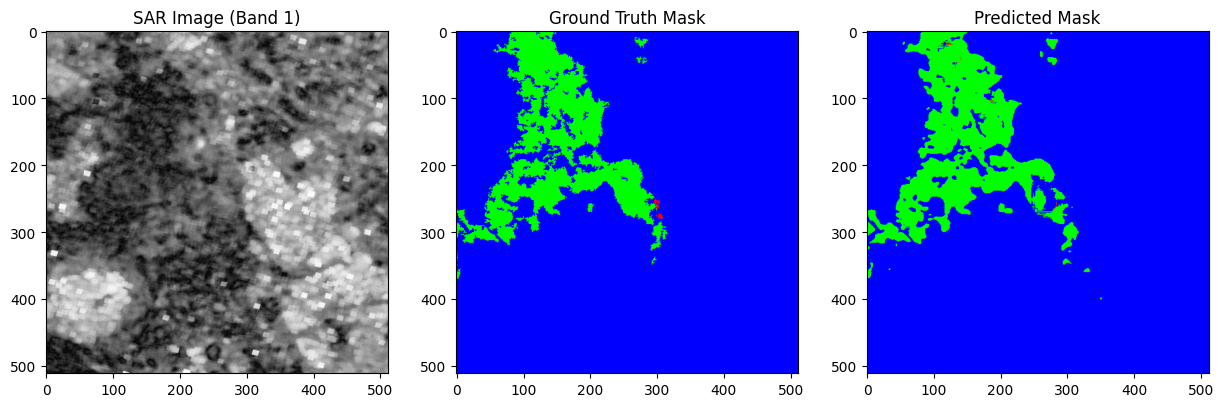

In [ ]:
import matplotlib.pyplot as plt

# Define a color map for the 3 classes (e.g., blue for class 0, green for class 1, red for class 2)
def colorize_mask(mask):
    # Define color map: class 0 - blue, class 1 - green, class 2 - red
    color_map = np.array([[0, 0, 255],   # Blue for non-flooded
                          [0, 255, 0],   # Green for open flooded
                          [255, 0, 0]])  # Red for urban flooded
    color_mask = color_map[mask]
    return color_mask

# Colorize the predicted mask and the ground truth mask (if available)
predicted_mask_colored = colorize_mask(predicted_mask)
gt_mask_colored = colorize_mask(gt_mask)  # Optional if ground truth is available

# Plot SAR image, Ground Truth, and Predicted Mask
plt.figure(figsize=(15, 5))

# Plot SAR Image (visualize one band, e.g., the first band)
plt.subplot(1, 3, 1)
plt.imshow(sar_image[0], cmap='gray')  # Show the first band of the SAR image
plt.title("SAR Image (Band 1)")

# Plot Ground Truth Mask (if available)
plt.subplot(1, 3, 2)
plt.imshow(gt_mask_colored)
plt.title("Ground Truth Mask")

# Plot Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_colored)
plt.title("Predicted Mask")

plt.show()


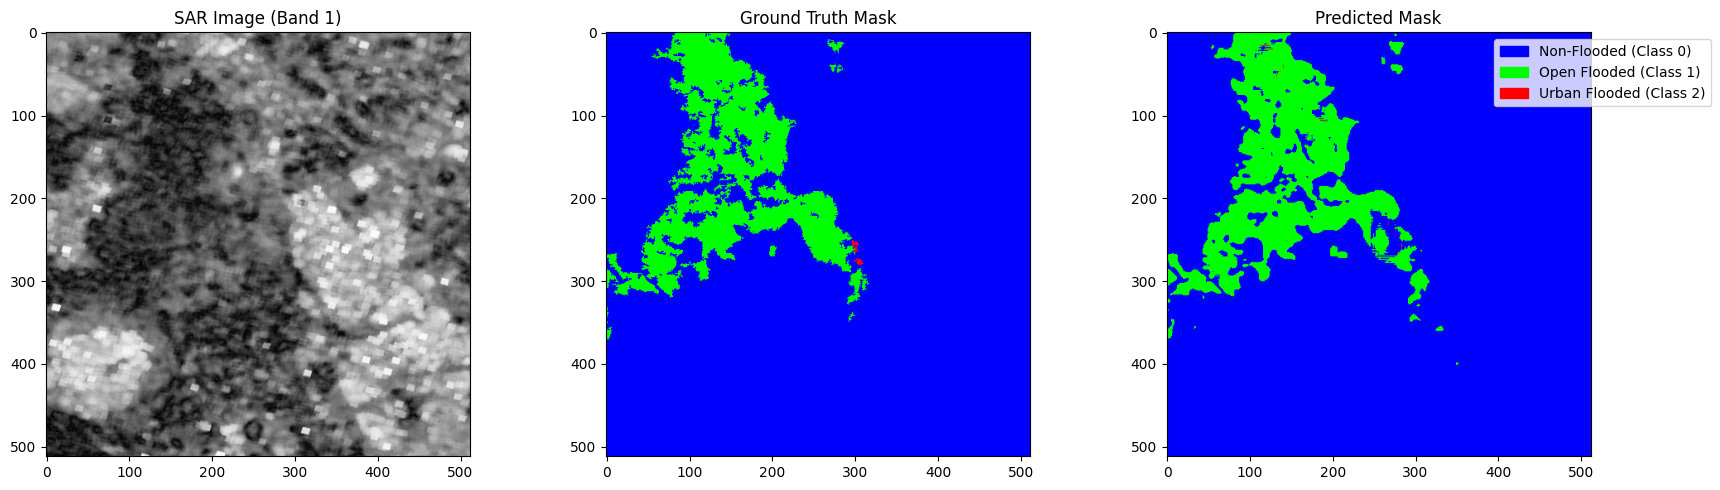

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define a color map for the 3 classes (e.g., blue for class 0, green for class 1, red for class 2)
def colorize_mask(mask):
    # Define color map: class 0 - blue, class 1 - green, class 2 - red
    color_map = np.array([[0, 0, 255],   # Blue for non-flooded
                          [0, 255, 0],   # Green for open flooded
                          [255, 0, 0]])  # Red for urban flooded
    color_mask = color_map[mask]
    return color_mask

# Create a legend with class labels and corresponding colors
def create_legend():
    # Create patches for the legend
    legend_patches = [
        mpatches.Patch(color=[0, 0, 1], label='Non-Flooded (Class 0)'),  # Blue
        mpatches.Patch(color=[0, 1, 0], label='Open Flooded (Class 1)'), # Green
        mpatches.Patch(color=[1, 0, 0], label='Urban Flooded (Class 2)') # Red
    ]
    return legend_patches

# Example mask arrays (predicted_mask and gt_mask need to be provided)
# predicted_mask = np.random.randint(0, 3, (512, 512))  # Example shape (512, 512)
# gt_mask = np.random.randint(0, 3, (512, 512))         # Example ground truth mask

# Colorize the predicted mask and the ground truth mask (if available)
predicted_mask_colored = colorize_mask(predicted_mask)
gt_mask_colored = colorize_mask(gt_mask)  # Optional if ground truth is available

# Plot SAR image, Ground Truth, and Predicted Mask
plt.figure(figsize=(18, 5))

# Plot SAR Image (visualize one band, e.g., the first band)
plt.subplot(1, 3, 1)
plt.imshow(sar_image[0], cmap='gray')  # Show the first band of the SAR image
plt.title("SAR Image (Band 1)")

# Plot Ground Truth Mask (if available)
plt.subplot(1, 3, 2)
plt.imshow(gt_mask_colored)
plt.title("Ground Truth Mask")

# Plot Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_colored)
plt.title("Predicted Mask")

# Add color legend for the classes
plt.legend(handles=create_legend(), loc='upper right', bbox_to_anchor=(1.3, 1))

# Show the plot
plt.tight_layout()
plt.show()


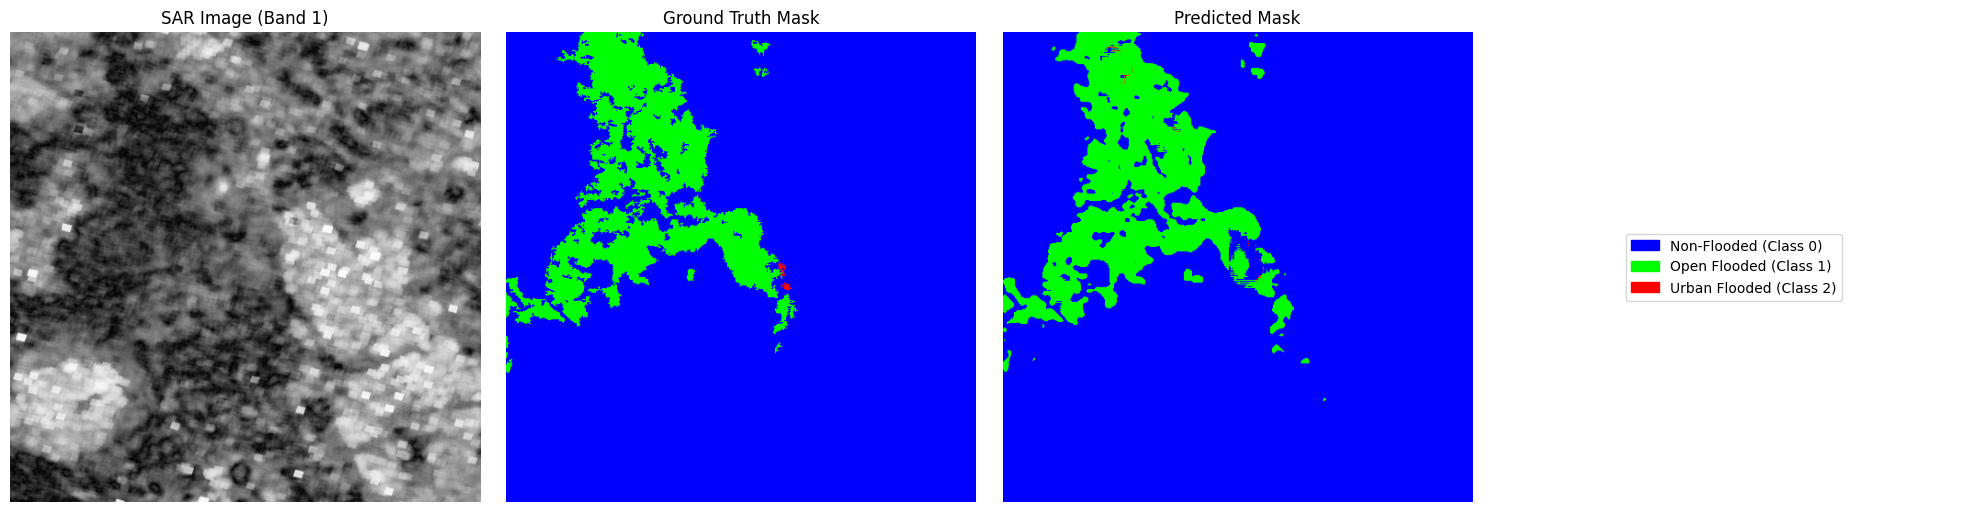

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define a color map for the 3 classes (e.g., blue for class 0, green for class 1, red for class 2)
def colorize_mask(mask):
    # Define color map: class 0 - blue, class 1 - green, class 2 - red
    color_map = np.array([[0, 0, 255],   # Blue for non-flooded
                          [0, 255, 0],   # Green for open flooded
                          [255, 0, 0]])  # Red for urban flooded
    color_mask = color_map[mask]
    return color_mask

# Create a legend with class labels and corresponding colors
def create_legend():
    # Create patches for the legend
    legend_patches = [
        mpatches.Patch(color=[0, 0, 1], label='Non-Flooded (Class 0)'),  # Blue
        mpatches.Patch(color=[0, 1, 0], label='Open Flooded (Class 1)'), # Green
        mpatches.Patch(color=[1, 0, 0], label='Urban Flooded (Class 2)') # Red
    ]
    return legend_patches

# Example mask arrays (predicted_mask and gt_mask need to be provided)
# predicted_mask = np.random.randint(0, 3, (512, 512))  # Example shape (512, 512)
# gt_mask = np.random.randint(0, 3, (512, 512))         # Example ground truth mask

# Colorize the predicted mask and the ground truth mask (if available)
predicted_mask_colored = colorize_mask(predicted_mask)
gt_mask_colored = colorize_mask(gt_mask)  # Optional if ground truth is available

# Plot SAR image, Ground Truth, and Predicted Mask
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 4 subplots to leave space for the legend

# Plot SAR Image (visualize one band, e.g., the first band)
axes[0].imshow(sar_image[0], cmap='gray')  # Show the first band of the SAR image
axes[0].set_title("SAR Image (Band 1)")
axes[0].axis('off')  # Hide the axis for a cleaner look

# Plot Ground Truth Mask (if available)
axes[1].imshow(gt_mask_colored)
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Plot Predicted Mask
axes[2].imshow(predicted_mask_colored)
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

# Create an empty subplot for the legend
axes[3].axis('off')  # Turn off the axis for this subplot
legend_patches = create_legend()  # Generate the legend patches
legend = axes[3].legend(handles=legend_patches, loc='center', fontsize=10)  # Display the legend in the fourth subplot

# Show the plot
plt.tight_layout()
plt.show()


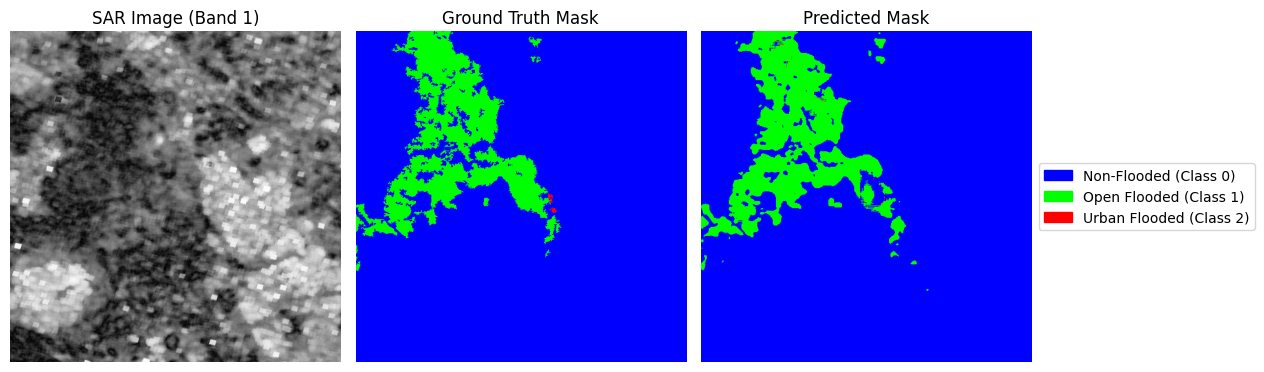

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define a color map for the 3 classes (e.g., blue for class 0, green for class 1, red for class 2)
def colorize_mask(mask):
    # Define color map: class 0 - blue, class 1 - green, class 2 - red
    color_map = np.array([[0, 0, 255],   # Blue for non-flooded
                          [0, 255, 0],   # Green for open flooded
                          [255, 0, 0]])  # Red for urban flooded
    color_mask = color_map[mask]
    return color_mask

# Create a legend with class labels and corresponding colors
def create_legend():
    # Create patches for the legend
    legend_patches = [
        mpatches.Patch(color=[0, 0, 1], label='Non-Flooded (Class 0)'),  # Blue
        mpatches.Patch(color=[0, 1, 0], label='Open Flooded (Class 1)'), # Green
        mpatches.Patch(color=[1, 0, 0], label='Urban Flooded (Class 2)') # Red
    ]
    return legend_patches

# Example mask arrays (predicted_mask and gt_mask need to be provided)
# predicted_mask = np.random.randint(0, 3, (512, 512))  # Example shape (512, 512)
# gt_mask = np.random.randint(0, 3, (512, 512))         # Example ground truth mask

# Colorize the predicted mask and the ground truth mask (if available)
predicted_mask_colored = colorize_mask(predicted_mask)
gt_mask_colored = colorize_mask(gt_mask)  # Optional if ground truth is available

# Plot SAR image, Ground Truth, and Predicted Mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 subplots for SAR, GT, and Prediction

# Plot SAR Image (visualize one band, e.g., the first band)
axes[0].imshow(sar_image[0], cmap='gray')  # Show the first band of the SAR image
axes[0].set_title("SAR Image (Band 1)")
axes[0].axis('off')  # Hide the axis for a cleaner look

# Plot Ground Truth Mask (if available)
axes[1].imshow(gt_mask_colored)
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Plot Predicted Mask
axes[2].imshow(predicted_mask_colored)
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

# Create the legend and place it outside the plot area
legend_patches = create_legend()  # Generate the legend patches
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)  # Position the legend outside the plot

# Adjust layout to ensure everything fits well
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Shrink plot area to make room for the legend

# Show the plot
plt.show()


In [ ]:
#### with weight

In [ ]:
import numpy as np
import torch
import os

def compute_class_weights(gt_dir, num_classes=3):
    """
    Compute class weights based on the inverse frequency of class occurrences in the ground truth masks.

    Args:
        gt_dir: Directory containing ground truth masks.
        num_classes: Number of classes.

    Returns:
        class_weights: Tensor containing weights for each class.
    """
    class_counts = np.zeros(num_classes)  # To store the pixel counts for each class
    total_pixels = 0  # Total number of pixels across all images

    # Iterate over the ground truth masks and compute the pixel counts
    for gt_file in os.listdir(gt_dir):
        gt_path = os.path.join(gt_dir, gt_file)
        gt_mask = load_mask(gt_path)  # Load the ground truth mask
        unique, counts = np.unique(gt_mask, return_counts=True)
        total_pixels += gt_mask.size

        # Update class counts
        for class_id, count in zip(unique, counts):
            class_counts[class_id] += count

    # Compute the inverse of the class frequencies (so that rarer classes get higher weight)
    class_weights = total_pixels / (num_classes * class_counts + 1e-8)  # Avoid division by zero
    class_weights = torch.tensor(class_weights).float().to(device)

    return class_weights


In [ ]:
import rasterio

# Load SAR image
def load_sar_image(image_path):
    with rasterio.open(image_path) as src:
        sar_image = src.read()  # Reads all bands (e.g., shape could be (8, 512, 512))
    return sar_image.astype(np.float32)

# Load ground truth mask
def load_mask(mask_path):
    with rasterio.open(mask_path) as src:
        gt_mask = src.read(1)  # Read first band for mask
    return gt_mask.astype(np.int64)


In [ ]:
from torch.utils.data import Dataset

class SARFloodDataset(Dataset):
    def __init__(self, sar_dir, gt_dir, transform=None):
        self.sar_dir = sar_dir
        self.gt_dir = gt_dir
        self.sar_images = sorted(os.listdir(sar_dir))
        self.gt_masks = sorted(os.listdir(gt_dir))
        self.transform = transform

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar_path = os.path.join(self.sar_dir, self.sar_images[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_masks[idx])

        sar_image = load_sar_image(sar_path)
        gt_mask = load_mask(gt_path)

        # Apply transformations (if any)
        if self.transform:
            sar_image = self.transform(sar_image)

        return sar_image, gt_mask


In [ ]:
import segmentation_models_pytorch as smp

# Define the U-Net model
model = smp.Unet(
    encoder_name="resnet34",        # Same encoder used during training
    encoder_weights=None,           # No pre-trained weights
    in_channels=8,                  # 8 input channels (SAR data with 8 bands)
    classes=3                       # 3 output classes (non-flooded, open flooded, urban flooded)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch.optim as optim

# Compute class weights from the ground truth masks directory
gt_dir = "/content/drive/MyDrive/FU/GT"  # Update this to the actual path
class_weights = compute_class_weights(gt_dir)

# Define the loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [ ]:
import numpy as np

def compute_confusion_metrics(predictions, ground_truth, num_classes=3):
    """
    Compute confusion matrix, precision, recall, f1-score, accuracy, and MCC based on
    true positive, true negative, false positive, and false negative for each class.
    """
    predictions = predictions.flatten()
    ground_truth = ground_truth.flatten()

    TP = np.zeros(num_classes)
    TN = np.zeros(num_classes)
    FP = np.zeros(num_classes)
    FN = np.zeros(num_classes)

    for class_id in range(num_classes):
        TP[class_id] = np.sum((predictions == class_id) & (ground_truth == class_id))
        TN[class_id] = np.sum((predictions != class_id) & (ground_truth != class_id))
        FP[class_id] = np.sum((predictions == class_id) & (ground_truth != class_id))
        FN[class_id] = np.sum((predictions != class_id) & (ground_truth == class_id))

    # Precision, Recall, F1 per class
    precision_per_class = np.where((TP + FP) > 0, TP / (TP + FP + 1e-8), np.nan)
    recall_per_class = np.where((TP + FN) > 0, TP / (TP + FN + 1e-8), np.nan)
    f1_per_class = np.where((precision_per_class + recall_per_class) > 0,
                            2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8),
                            np.nan)

    # Overall metrics
    total_TP = TP.sum()
    total_FP = FP.sum()
    total_FN = FN.sum()

    overall_precision = total_TP / (total_TP + total_FP + 1e-8)
    overall_recall = total_TP / (total_TP + total_FN + 1e-8)
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall + 1e-8)
    overall_accuracy = (TP.sum() + TN.sum()) / (TP.sum() + TN.sum() + FP.sum() + FN.sum())

    return precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy


In [ ]:
!pip install torchmetrics

In [ ]:
# Training loop for 100 epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for sar_image, gt_mask in train_loader:  # Assume train_loader is defined
        sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

        optimizer.zero_grad()
        outputs = model(sar_image)

        # Compute loss using class weights
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    total_TP, total_FP, total_FN = 0, 0, 0

    with torch.no_grad():
        for sar_image, gt_mask in val_loader:  # Assume val_loader is defined
            sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

            outputs = model(sar_image)
            loss = criterion(outputs, gt_mask)
            test_loss += loss.item()

            # Get predicted masks
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            ground_truth = gt_mask.cpu().numpy()

            # Compute metrics
            precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy = compute_confusion_metrics(predictions, ground_truth)

    # Print results for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}")
    print(f"Test Loss: {test_loss / len(val_loader):.4f}")
    print(f"Precision (per class): {precision_per_class}")
    print(f"Recall (per class): {recall_per_class}")
    print(f"F1 Score (per class): {f1_per_class}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Save model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"/path/to/save/unet_modelWithW_epoch_{epoch + 1}.pth")


KeyboardInterrupt: 

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 49.9 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MulticlassF1Score, MulticlassPrecision, MulticlassRecall, CohenKappa

In [ ]:
from torchmetrics.classification import MulticlassF1Score, MulticlassPrecision, MulticlassRecall, CohenKappa

In [ ]:
import os
import numpy as np
import torch
import torch.optim as optim
import rasterio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchmetrics.classification import MulticlassF1Score, MulticlassPrecision, MulticlassRecall, CohenKappa

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Load SAR image
def load_sar_image(image_path):
    with rasterio.open(image_path) as src:
        sar_image = src.read()  # Reads all bands (e.g., shape could be (8, 512, 512))
    return sar_image.astype(np.float32)

# Load ground truth mask
def load_mask(mask_path):
    with rasterio.open(mask_path) as src:
        gt_mask = src.read(1)  # Read first band for mask
    return gt_mask.astype(np.int64)


In [ ]:
class SARFloodDataset(Dataset):
    def __init__(self, sar_dir, gt_dir, transform=None):
        self.sar_dir = sar_dir
        self.gt_dir = gt_dir
        self.sar_images = sorted(os.listdir(sar_dir))
        self.gt_masks = sorted(os.listdir(gt_dir))
        self.transform = transform

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar_path = os.path.join(self.sar_dir, self.sar_images[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_masks[idx])

        sar_image = load_sar_image(sar_path)
        gt_mask = load_mask(gt_path)

        # Apply transformations (if any)
        if self.transform:
            sar_image = self.transform(sar_image)

        return sar_image, gt_mask


In [ ]:
def compute_class_weights(gt_dir, num_classes=3):
    """
    Compute class weights based on the inverse frequency of class occurrences in the ground truth masks.
    """
    class_counts = np.zeros(num_classes)
    total_pixels = 0

    for gt_file in os.listdir(gt_dir):
        gt_path = os.path.join(gt_dir, gt_file)
        gt_mask = load_mask(gt_path)
        unique, counts = np.unique(gt_mask, return_counts=True)
        total_pixels += gt_mask.size

        for class_id, count in zip(unique, counts):
            class_counts[class_id] += count

    # Compute the inverse of the class frequencies
    class_weights = total_pixels / (num_classes * class_counts + 1e-8)
    class_weights = torch.tensor(class_weights).float().to(device)

    return class_weights


In [ ]:
# Define directories
#sar_dir = "/path/to/SAR"  # Update to your SAR images directory
#gt_dir = "/path/to/GT"    # Update to your ground truth masks directory
sar_dir = "/content/drive/MyDrive/FU/SAR"  # Path to SAR images
gt_dir = "/content/drive/MyDrive/FU/GT"

# Compute class weights
class_weights = compute_class_weights(gt_dir)

# Initialize Dataset
train_dataset = SARFloodDataset(sar_dir, gt_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# For evaluation (you can use the same dataset for simplicity, or split it)
val_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)


In [ ]:
# Define the U-Net model with ResNet encoder
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=8,
    classes=3
)

# Move model to GPU if available
model = model.to(device)


In [ ]:
# Define the loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [ ]:
def compute_confusion_metrics(predictions, ground_truth, num_classes=3):
    """
    Compute confusion matrix, precision, recall, f1-score, accuracy, and MCC based on
    true positive, true negative, false positive, and false negative for each class.
    """
    predictions = predictions.flatten()
    ground_truth = ground_truth.flatten()

    TP = np.zeros(num_classes)
    TN = np.zeros(num_classes)
    FP = np.zeros(num_classes)
    FN = np.zeros(num_classes)

    for class_id in range(num_classes):
        TP[class_id] = np.sum((predictions == class_id) & (ground_truth == class_id))
        TN[class_id] = np.sum((predictions != class_id) & (ground_truth != class_id))
        FP[class_id] = np.sum((predictions == class_id) & (ground_truth != class_id))
        FN[class_id] = np.sum((predictions != class_id) & (ground_truth == class_id))

    # Precision, Recall, F1 per class
    precision_per_class = np.where((TP + FP) > 0, TP / (TP + FP + 1e-8), np.nan)
    recall_per_class = np.where((TP + FN) > 0, TP / (TP + FN + 1e-8), np.nan)
    f1_per_class = np.where((precision_per_class + recall_per_class) > 0,
                            2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8),
                            np.nan)

    # Overall metrics
    total_TP = TP.sum()
    total_FP = FP.sum()
    total_FN = FN.sum()

    overall_precision = total_TP / (total_TP + total_FP + 1e-8)
    overall_recall = total_TP / (total_TP + total_FN + 1e-8)
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall + 1e-8)
    overall_accuracy = (TP.sum() + TN.sum()) / (TP.sum() + TN.sum() + FP.sum() + FN.sum())

    return precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy


In [ ]:
import numpy as np

def compute_confusion_metrics(predictions, ground_truth, num_classes=3):
    """
    Compute confusion matrix, precision, recall, f1-score, accuracy, and MCC (Matthews Correlation Coefficient)
    based on true positive, true negative, false positive, and false negative for each class.
    """
    # Flatten the predictions and ground truth to 1D arrays
    predictions = predictions.flatten()
    ground_truth = ground_truth.flatten()

    # Initialize TP, TN, FP, FN for each class
    TP = np.zeros(num_classes)
    TN = np.zeros(num_classes)
    FP = np.zeros(num_classes)
    FN = np.zeros(num_classes)

    # Calculate TP, TN, FP, FN for each class
    for class_id in range(num_classes):
        TP[class_id] = np.sum((predictions == class_id) & (ground_truth == class_id))
        TN[class_id] = np.sum((predictions != class_id) & (ground_truth != class_id))
        FP[class_id] = np.sum((predictions == class_id) & (ground_truth != class_id))
        FN[class_id] = np.sum((predictions != class_id) & (ground_truth == class_id))

    # Precision, Recall, F1 per class
    precision_per_class = np.where((TP + FP) > 0, TP / (TP + FP + 1e-8), np.nan)
    recall_per_class = np.where((TP + FN) > 0, TP / (TP + FN + 1e-8), np.nan)
    f1_per_class = np.where((precision_per_class + recall_per_class) > 0,
                            2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8),
                            np.nan)

    # Matthews Correlation Coefficient (MCC) per class
    mcc_per_class = np.where(
        (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) > 0,  # Ensure no division by zero
        (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) + 1e-8),
        np.nan
    )

    # Overall metrics
    total_TP = TP.sum()
    total_TN = TN.sum()
    total_FP = FP.sum()
    total_FN = FN.sum()

    overall_precision = total_TP / (total_TP + total_FP + 1e-8)
    overall_recall = total_TP / (total_TP + total_FN + 1e-8)
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall + 1e-8)
    overall_accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN)

    # Overall MCC
    overall_mcc = (total_TP * total_TN - total_FP * total_FN) / np.sqrt(
        (total_TP + total_FP) * (total_TP + total_FN) * (total_TN + total_FP) * (total_TN + total_FN) + 1e-8
    )

    return precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy, mcc_per_class, overall_mcc


In [ ]:
# Training loop for 100 epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for sar_image, gt_mask in train_loader:
        sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

        optimizer.zero_grad()
        outputs = model(sar_image)

        # Compute loss using class weights
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0

    with torch.no_grad():
        for sar_image, gt_mask in val_loader:
            sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

            outputs = model(sar_image)
            loss = criterion(outputs, gt_mask)
            test_loss += loss.item()

            # Get predicted masks
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            ground_truth = gt_mask.cpu().numpy()

            # Compute metrics
            precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy = compute_confusion_metrics(predictions, ground_truth)

    # Print results for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}")
    print(f"Test Loss: {test_loss / len(val_loader):.4f}")
    print(f"Precision (per class): {precision_per_class}")
    print(f"Recall (per class): {recall_per_class}")
    print(f"F1 Score (per class): {f1_per_class}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Save model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/unet_modelWithW_epoch_{epoch + 1}.pth")


Epoch 1/100
Train Loss: 0.9341
Test Loss: 0.8933
Precision (per class): [0.99941551 0.07869646 0.00184994]
Recall (per class): [0.31523737 0.99194171 0.80265849]
F1 Score (per class): [0.47929475 0.14582388 0.00369136]
Overall Precision: 0.3384
Overall Recall: 0.3384
Overall F1 Score: 0.3384
Overall Accuracy: 0.5589
Epoch 2/100
Train Loss: 0.7460
Test Loss: 0.7243
Precision (per class): [0.99967313 0.08531982 0.00698196]
Recall (per class): [0.5497339  0.99585789 0.8404908 ]
F1 Score (per class): [0.70937358 0.15717382 0.01384888]
Overall Precision: 0.5650
Overall Recall: 0.5650
Overall F1 Score: 0.5650
Overall Accuracy: 0.7100
Epoch 3/100
Train Loss: 0.6269
Test Loss: 0.6007
Precision (per class): [0.9995985  0.11469853 0.00153774]
Recall (per class): [0.35080358 0.99572609 0.91002045]
F1 Score (per class): [0.51934566 0.20570206 0.00307029]
Overall Precision: 0.3729
Overall Recall: 0.3729
Overall F1 Score: 0.3729
Overall Accuracy: 0.5820
Epoch 4/100
Train Loss: 0.4916
Test Loss: 0.48

In [ ]:
# Load the saved model checkpoint
checkpoint_path = "/content/drive/MyDrive/unet_modelWithW_epoch_170.pth"

# Rebuild the U-Net model
model = smp.Unet(
    encoder_name="resnet34",        # Same encoder used during training
    encoder_weights=None,           # No pre-trained weights
    in_channels=8,                  # 8 input channels (SAR data with 8 bands)
    classes=3                       # 3 output classes
)

# Move model to GPU if available
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)
model.eval()  # Set model to evaluation mode


<ipython-input-27-7c677805575f>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# Load and preprocess the test SAR image
test_sar_image_path = "/content/drive/MyDrive/TOTAL TEST/test/SAR/20210324_Sydney_ID_22_20_SAR.tif"  # Update to your actual image path
test_gt_mask_path = "/content/drive/MyDrive/TOTAL TEST/test/GT/20210324_Sydney_ID_22_20_GT.tif"  # Update to your actual ground truth mask path

# Load the SAR image and ground truth mask
sar_image = load_sar_image(test_sar_image_path)
gt_mask = load_mask(test_gt_mask_path)

# Convert the SAR image to tensor and add batch dimension
sar_image_tensor = torch.tensor(sar_image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
gt_mask_tensor = torch.tensor(gt_mask).unsqueeze(0).to(device)  # Optional for comparison and move to GPU


In [ ]:
# Perform inference
with torch.no_grad():
    outputs = model(sar_image_tensor)
    predicted_mask = torch.argmax(outputs, dim=1).cpu().numpy()  # Get predicted mask and convert to numpy


In [ ]:
# Compute metrics
precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy = compute_confusion_metrics(predicted_mask, gt_mask)

# Print metrics
print(f"Precision (per class): {precision_per_class}")
print(f"Recall (per class): {recall_per_class}")
print(f"F1 Score (per class): {f1_per_class}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")


Precision (per class): [0.99998619 0.72604588 0.23031496]
Recall (per class): [0.94533195 0.99953553 1.        ]
F1 Score (per class): [0.9718913  0.84111784 0.3744    ]
Overall Precision: 0.9520
Overall Recall: 0.9520
Overall F1 Score: 0.9520
Overall Accuracy: 0.9680


In [ ]:
# Compute metrics
precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy, mcc_per_class, overall_mcc = compute_confusion_metrics(predicted_mask, gt_mask)

# Print per-class metrics
print(f"Precision (per class): {precision_per_class}")
print(f"Recall (per class): {recall_per_class}")
print(f"F1 Score (per class): {f1_per_class}")
print(f"MCC (per class): {mcc_per_class}")

# Print overall metrics
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall MCC: {overall_mcc:.4f}")


Precision (per class): [0.99998619 0.72604588 0.23031496]
Recall (per class): [0.94533195 0.99953553 1.        ]
F1 Score (per class): [0.9718913  0.84111784 0.3744    ]
MCC (per class): [0.82536828 0.82895676 0.47955321]
Overall Precision: 0.9520
Overall Recall: 0.9520
Overall F1 Score: 0.9520
Overall Accuracy: 0.9680
Overall MCC: 0.9281


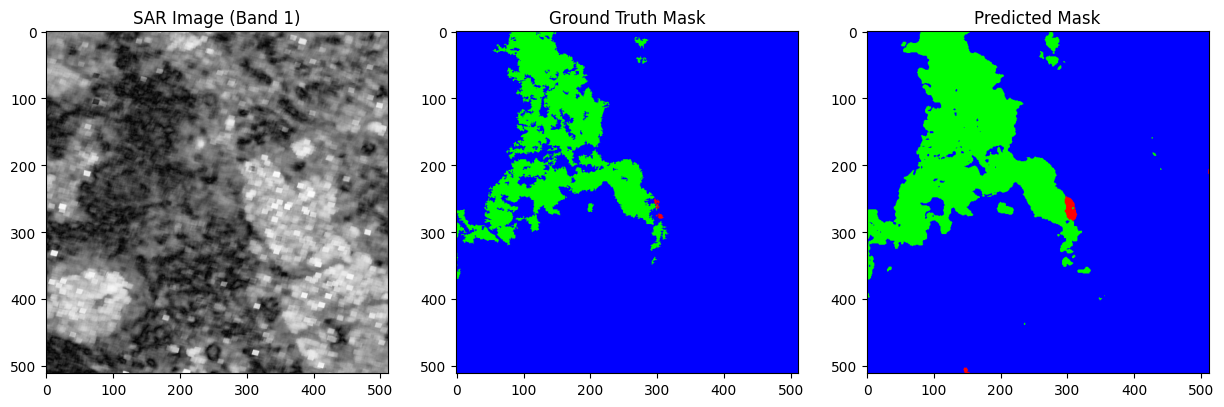

In [ ]:
def colorize_mask(mask):
    # Define color map for 3 classes: [0, 1, 2]
    color_map = np.array([[0, 0, 255],   # Class 0: blue (non-flooded)
                          [0, 255, 0],   # Class 1: green (open flooded)
                          [255, 0, 0]])  # Class 2: red (urban flooded)
    color_mask = color_map[mask]
    return color_mask

# Colorize the predicted mask and the ground truth mask
#predicted_mask_colored = colorize_mask(predicted_mask)
#gt_mask_colored = colorize_mask(gt_mask)
predicted_mask_colored = colorize_mask(predicted_mask[0]) # Remove batch dimension here
gt_mask_colored = colorize_mask(gt_mask)

# Plot SAR image, Ground Truth, and Predicted Mask
plt.figure(figsize=(15, 5))

# Plot SAR Image (first band)
plt.subplot(1, 3, 1)
plt.imshow(sar_image[0], cmap='gray')  # Show the first band of the SAR image
plt.title("SAR Image (Band 1)")

# Plot Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(gt_mask_colored)
plt.title("Ground Truth Mask")

# Plot Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_colored)
plt.title("Predicted Mask")

plt.show()


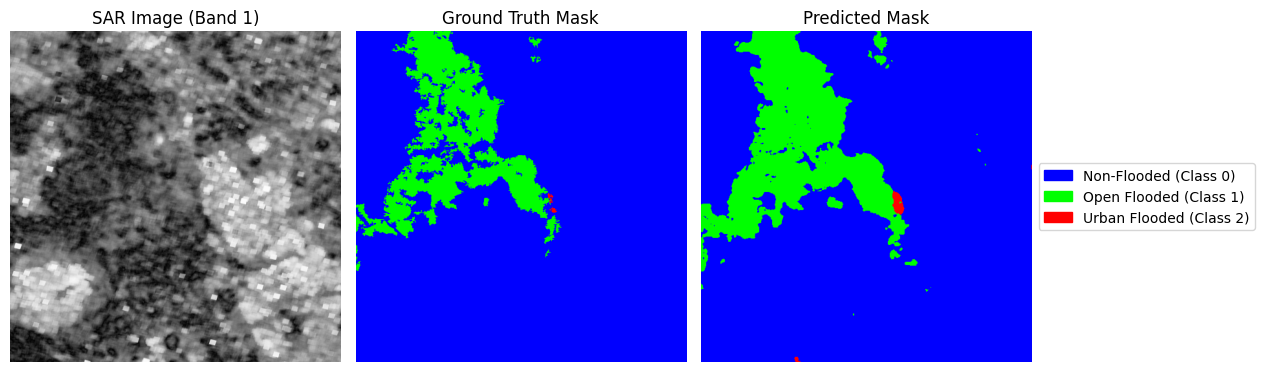

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define a color map for the 3 classes
def colorize_mask(mask):
    # Define color map: class 0 - blue, class 1 - green, class 2 - red
    color_map = np.array([[0, 0, 255],   # Blue for non-flooded
                          [0, 255, 0],   # Green for open flooded
                          [255, 0, 0]])  # Red for urban flooded
    color_mask = color_map[mask]
    return color_mask

# Create a legend with class labels and corresponding colors
def create_legend():
    # Create patches for the legend
    legend_patches = [
        mpatches.Patch(color=[0, 0, 1], label='Non-Flooded (Class 0)'),  # Blue
        mpatches.Patch(color=[0, 1, 0], label='Open Flooded (Class 1)'), # Green
        mpatches.Patch(color=[1, 0, 0], label='Urban Flooded (Class 2)') # Red
    ]
    return legend_patches

# Assuming you have your predicted_mask and gt_mask already available
# Remove the batch dimension if necessary
predicted_mask_colored = colorize_mask(predicted_mask[0])  # Remove batch dimension
gt_mask_colored = colorize_mask(gt_mask)

# Plot SAR image, Ground Truth, and Predicted Mask
plt.figure(figsize=(15, 5))

# Plot SAR Image (visualize one band, e.g., the first band)
plt.subplot(1, 3, 1)
plt.imshow(sar_image[0], cmap='gray')  # Show the first band of the SAR image
plt.title("SAR Image (Band 1)")
plt.axis('off')

# Plot Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(gt_mask_colored)
plt.title("Ground Truth Mask")
plt.axis('off')

# Plot Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_colored)
plt.title("Predicted Mask")
plt.axis('off')

# Create the legend and place it outside the plot area
legend_patches = create_legend()  # Generate the legend patches
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

# Adjust layout to ensure everything fits well
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Shrink plot area to make room for the legend

# Show the plot
plt.show()


In [ ]:
# Load the saved model checkpoint from the 150th epoch
checkpoint_path = "/content/drive/MyDrive/unet_modelWithW_epoch_150.pth"

# Rebuild the U-Net model with the same configuration
model = smp.Unet(
    encoder_name="resnet34",        # Same encoder used during training
    encoder_weights=None,           # No pre-trained weights (use your checkpoint)
    in_channels=8,                  # 8 input channels (SAR data with 8 bands)
    classes=3                       # 3 output classes (e.g., non-flooded, open flooded, urban flooded)
)

# Load the model state dictionary from the checkpoint
model.load_state_dict(torch.load(checkpoint_path))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Set to evaluation mode for loading


<ipython-input-13-776593842413>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# Directory containing ground truth masks
gt_dir = "/content/drive/MyDrive/FU/GT"

# Compute class weights
class_weights = compute_class_weights(gt_dir, num_classes=3)

# Print computed class weights for verification
print(f"Computed Class Weights: {class_weights}")


Computed Class Weights: tensor([  0.3431,  12.7087, 146.4834], device='cuda:0')


In [ ]:
# Define loss function with the computed class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
# Continue training from the 151st to 250th epoch
start_epoch = 151
num_epochs = 250

for epoch in range(start_epoch, num_epochs + 1):
    model.train()  # Set model to training mode
    train_loss = 0

    for sar_image, gt_mask in train_loader:  # Train loader for batch processing
        sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

        optimizer.zero_grad()
        outputs = model(sar_image)

        # Compute loss using class weights
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0

    with torch.no_grad():
        for sar_image, gt_mask in val_loader:  # Validation loader for evaluation
            sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

            outputs = model(sar_image)
            loss = criterion(outputs, gt_mask)
            test_loss += loss.item()

            # Get predicted masks
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            ground_truth = gt_mask.cpu().numpy()

            # Compute metrics
            precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy = compute_confusion_metrics(predictions, ground_truth)

    # Print results for each epoch
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}")
    print(f"Test Loss: {test_loss / len(val_loader):.4f}")
    print(f"Precision (per class): {precision_per_class}")
    print(f"Recall (per class): {recall_per_class}")
    print(f"F1 Score (per class): {f1_per_class}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Save model every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/unet_modelWithW_epoch_{epoch}.pth")


Epoch 151/250
Train Loss: 0.0327
Test Loss: 0.0295
Precision (per class): [0.99998163 0.53786843 0.2078198 ]
Recall (per class): [0.96751391 0.99949165 1.        ]
F1 Score (per class): [0.98347987 0.69937421 0.34412385]
Overall Precision: 0.9686
Overall Recall: 0.9686
Overall F1 Score: 0.9686
Overall Accuracy: 0.9791
Epoch 152/250
Train Loss: 0.0324
Test Loss: 0.0290
Precision (per class): [0.9999735  0.54904517 0.20511745]
Recall (per class): [0.96880245 0.99926572 1.        ]
F1 Score (per class): [0.98414121 0.70869748 0.34041072]
Overall Precision: 0.9699
Overall Recall: 0.9699
Overall F1 Score: 0.9699
Overall Accuracy: 0.9799
Epoch 153/250
Train Loss: 0.0344
Test Loss: 0.0290
Precision (per class): [0.99997418 0.55520105 0.18324902]
Recall (per class): [0.96913298 0.99928454 1.        ]
F1 Score (per class): [0.98431205 0.71381019 0.30973871]
Overall Precision: 0.9702
Overall Recall: 0.9702
Overall F1 Score: 0.9702
Overall Accuracy: 0.9801
Epoch 154/250
Train Loss: 0.0329
Test Lo

In [ ]:
# Directory containing ground truth masks
gt_dir = "/content/drive/MyDrive/FU/GT"

# Compute class weights
class_weights = compute_class_weights(gt_dir, num_classes=3)

# Print computed class weights for verification
print(f"Computed Class Weights: {class_weights}")


Computed Class Weights: tensor([  0.3431,  12.7087, 146.4834], device='cuda:0')


In [ ]:
# Define loss function with the computed class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
import os
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

# Assuming load_mask is defined to load ground truth masks
# Assuming train_loader and val_loader are defined

def compute_class_weights(gt_dir, num_classes=3):
    class_counts = np.zeros(num_classes)
    total_pixels = 0

    for gt_file in os.listdir(gt_dir):
        gt_path = os.path.join(gt_dir, gt_file)
        gt_mask = load_mask(gt_path)
        unique, counts = np.unique(gt_mask, return_counts=True)
        total_pixels += gt_mask.size

        for class_id, count in zip(unique, counts):
            class_counts[class_id] += count

    class_weights = total_pixels / (num_classes * class_counts + 1e-8)
    class_weights = torch.tensor(class_weights).float().to(device)

    return class_weights

# Load your dataset
gt_dir = "/content/drive/MyDrive/FU/GT"
class_weights = compute_class_weights(gt_dir, num_classes=3)
print(f"Class Weights: {class_weights}")

# Initialize model, optimizer, and loss function
model = smp.Unet(
    encoder_name="resnet34",        # Use ResNet34 encoder
    encoder_weights=None,           # No pre-trained weights (initialize from scratch)
    in_channels=8,                  # 8 channels for SAR data
    classes=3                       # 3 classes for segmentation
)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define the loss function using the computed class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop for continuing from epoch 151 to 250
start_epoch = 151
num_epochs = 250
for epoch in range(start_epoch, num_epochs + 1):
    model.train()  # Set model to training mode
    train_loss = 0

    for sar_image, gt_mask in train_loader:
        sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

        optimizer.zero_grad()
        outputs = model(sar_image)

        # Compute loss using class weights
        loss = criterion(outputs, gt_mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0

    with torch.no_grad():
        for sar_image, gt_mask in val_loader:
            sar_image, gt_mask = sar_image.to(device), gt_mask.to(device)

            outputs = model(sar_image)
            loss = criterion(outputs, gt_mask)
            test_loss += loss.item()

            # Get predicted masks
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            ground_truth = gt_mask.cpu().numpy()

            # Compute metrics
            precision_per_class, recall_per_class, f1_per_class, overall_precision, overall_recall, overall_f1, overall_accuracy = compute_confusion_metrics(predictions, ground_truth)

    # Print results for each epoch
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}")
    print(f"Test Loss: {test_loss / len(val_loader):.4f}")
    print(f"Precision (per class): {precision_per_class}")
    print(f"Recall (per class): {recall_per_class}")
    print(f"F1 Score (per class): {f1_per_class}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Save model every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/unet_modelWithW_epoch_{epoch}.pth")


Class Weights: tensor([  0.3431,  12.7087, 146.4834], device='cuda:0')
